In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes, load_wine
from sklearn.mixture import GaussianMixture
import os
os.environ["OMP_NUM_THREADS"] = '3'
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score, classification_report, confusion_matrix, accuracy_score, silhouette_score, homogeneity_score, mean_squared_error, f1_score, davies_bouldin_score 
from numpy import linalg as la
from numba import njit
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
pima_data = pd.read_csv('diabetes.csv')
wine_data = pd.read_csv('wine_quality.csv')

y_pima = pima_data['Outcome']
X_pima = pima_data.drop('Outcome', axis=1)

y_wine = wine_data['quality']
X_wine = wine_data.drop('quality', axis=1)

# Split data into train/test splits
X_train_pima, X_test_pima, y_train_pima, y_test_pima = train_test_split(X_pima, y_pima, test_size=0.2, random_state=42)
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42)


# Normalize the data for some algorithms
scaler = StandardScaler()
scaler.fit(X_train_pima)
X_train_pima = scaler.transform(X_train_pima)
X_train_pima = pd.DataFrame(X_train_pima, columns=X_pima.columns)

scaler2 = StandardScaler()
scaler2.fit(X_train_wine)
X_train_wine = scaler2.transform(X_train_wine)
X_train_wine = pd.DataFrame(X_train_wine, columns=X_wine.columns)

In [3]:
def getSilhouette(X, y):
    silh = {}
    for cluster in range(2, 20):
        kmeans = KMeans(n_clusters=cluster, n_init=10, max_iter=1000, random_state=42).fit(X)
        label = kmeans.labels_
        sil_coeff = silhouette_score(X, label, metric='euclidean')
        silh[cluster] = sil_coeff
        
    plt.figure()
    plt.plot(list(silh.keys()), list(silh.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

In [4]:
def getHomogeneity(X, y):
    homog = {}
    for cluster in range(2, 20):
        kmeans = KMeans(n_clusters=cluster, n_init=10, max_iter=1000, random_state=42).fit(X)
        label = kmeans.labels_
        homog_score = homogeneity_score(y, label)
        homog[cluster] = homog_score
        
    plt.figure()
    plt.plot(list(homog.keys()), list(homog.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("Homogeneity Score")
    plt.show()

In [ ]:
homog = {}
for cluster in range(2, 20):
    em = GaussianMixture(n_components=2, random_state=42, n_init=10).fit(X_pima)
    label = em.predict(X_pima)
    homog_score = homogeneity_score(y_pima, label)
    homog[cluster] = homog_score
        
plt.figure()
plt.plot(list(homog.keys()), list(homog.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Homogeneity Score")
plt.show()

In [ ]:
silh = {}

for cluster in range(2, 20):
    em = GaussianMixture(n_components=cluster, random_state=42, n_init=10).fit(X_wine)
    label = em.predict(X_wine)
    sil_coeff = homogeneity_score(y_wine, label)
    silh[cluster] = sil_coeff
    
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Homogeneity Score")
plt.show()

In [ ]:
getSilhouette(X_pima, y_pima)

In [ ]:
getSilhouette(X_wine, y_wine)

In [ ]:
getHomogeneity(X_wine, y_wine)

In [ ]:
getHomogeneity(X_pima, y_pima)

In [5]:
def run_clustering(X):
    
    # Clustering algorithms
    em = GaussianMixture(n_components=2, random_state=42, n_init=10).fit(X)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=1000).fit(X)

    em_clusters = em.predict(X)
    kmeans_clusters = kmeans.predict(X)

    return em_clusters, kmeans_clusters

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=10).fit(X_pima)
y_kmeans = kmeans.predict(X_pima)
f1_score((1-kmeans.labels_), y_pima, average="weighted")

In [ ]:
# Visualizing the clusters
plt.figure(figsize=(8, 6))

plt.scatter(x=pima_data.iloc[:,0],y=pima_data.iloc[:,1],c=y_kmeans, cmap='plasma', edgecolor='k')

# Centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='o', label='Centroids')
plt.title('K-means Clustering')
plt.legend()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=10).fit(X_pima)
f1_score((1-kmeans.labels_), y_pima, average="weighted")

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=10).fit(X_wine)
f1_score((1-kmeans.labels_), y_wine, average="weighted")

In [ ]:
f1_scores = {}  # Use a different variable name to store F1 scores

for cluster in range(2, 50):
    em = GaussianMixture(n_components=cluster, random_state=42, n_init=10).fit(X_wine)
    labels = kmeans.labels_  # Get cluster labels
    score = f1_score((1-labels), y_wine, average="weighted")
    f1_scores[cluster] = score

plt.figure()
plt.plot(list(f1_scores.keys()), list(f1_scores.values()))
plt.xlabel("Number of clusters")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
em = GaussianMixture(n_components=3, random_state=42, n_init=10).fit(X_wine)
labels = em.predict(X_wine)
adjusted_mutual_info_score((1-labels), y_wine)

In [ ]:
em = GaussianMixture(n_components=2, random_state=42, n_init=10).fit(X_wine)
labels = em.predict(X_wine)
adjusted_mutual_info_score((1-labels), y_wine)

In [ ]:
%%time

f1_scores = {}  # Use a different variable name to store F1 scores

for cluster in range(2, 20):
    em = GaussianMixture(n_components=cluster, random_state=42, n_init=10).fit(X_wine)
    labels = em.predict(X_wine)  # Get cluster labels
    score = adjusted_mutual_info_score((1-labels), y_wine)
    f1_scores[cluster] = score

plt.figure()
plt.plot(list(f1_scores.keys()), list(f1_scores.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Adjusted Mutual Information Score")
plt.show()

In [6]:
def run_dimensionality_reduction(X):
    # Dimensionality reduction algorithms
    pca = PCA(n_components=4, random_state=42)        
    ica = FastICA(n_components=4, random_state=42)
    rp = GaussianRandomProjection(n_components=4, random_state=42)
    
    # reconstruction
    pca_data = pca.fit_transform(X.values)
    A = la.pinv(pca.components_.T)
    reconstructed = np.dot(pca_data, A)
    rc_err = mean_squared_error(X.values, reconstructed)    
    print("Reconstruction error for PCA:", sum(pca.explained_variance_ratio_), rc_err)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    # reconstruction
    ica_data = ica.fit_transform(X.values)
    A = la.pinv(ica.components_.T)
    reconstructed = np.dot(ica_data, A)
    rc_err = mean_squared_error(X.values, reconstructed)    
    print("Reconstruction error for ICA:", rc_err)
    
    # reconstruction
    rp_data = rp.fit_transform(X.values)
    A = la.pinv(rp.components_.T)
    reconstructed = np.dot(rp_data, A)
    rc_err = mean_squared_error(X.values, reconstructed)    
    print("Reconstruction error for RCA:", rc_err)
    
    return pca_data, ica_data, rp_data

In [ ]:
sse = {}

for i in range(1, 9):
    rp = GaussianRandomProjection(n_components=i, random_state=42)
    rp_data = rp.fit_transform(X_wine.values)
    
    A = la.pinv(rp.components_.T)
    reconstructed = np.dot(rp_data, A)
    rc_err = np.sqrt(mean_squared_error(X_wine.values, reconstructed))
    sse[i] = rc_err
    
# Visualizing the clusters
plt.figure(figsize=(8, 6))

plt.plot(list(sse.keys()), list(sse.values()))

plt.title('Gaussian Random Projections')
plt.xlabel("# of Dimensions")
plt.ylabel("Square Root of Reconstruction Error")
plt.show()

In [7]:
def run_manifold_learning(data):
    tsne = TSNE(n_components=3, random_state=42)
    tsne_data = tsne.fit_transform(data.values)

    return tsne_data

In [8]:
%%time
diabetes_em_clusters, diabetes_kmeans_clusters = run_clustering(X_pima)
wine_em_clusters, wine_kmeans_clusters = run_clustering(X_wine)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

CPU times: total: 28.1 s
Wall time: 7.49 s


In [111]:
%%time
diabetes_pca, diabetes_ica, diabetes_rp = run_dimensionality_reduction(X_pima)
wine_pca, wine_ica, wine_rp = run_dimensionality_reduction(X_wine)

Reconstruction error for PCA: 0.9890136746543028 3561.3013249035266
Explained variation per principal component: [0.88854663 0.06159078 0.02579012 0.01308614]
Reconstruction error for ICA: 3561.301324903527
Reconstruction error for RCA: 4625.546379778276
Reconstruction error for PCA: 0.9999991335700872 501721.02406484267
Explained variation per principal component: [9.98963021e-01 9.42576295e-04 8.28146774e-05 1.07216436e-05]
Reconstruction error for ICA: 501721.02406484267
Reconstruction error for RCA: 606319.3034489142
CPU times: total: 62.5 ms
Wall time: 100 ms


In [112]:
%%time

diabetes_tsne = run_manifold_learning(X_pima)
wine_tsne = run_manifold_learning(X_wine)

CPU times: total: 7min 30s
Wall time: 1min 5s


In [116]:
diabetes_pca = pd.DataFrame(diabetes_pca)
diabetes_ica = pd.DataFrame(diabetes_ica)
diabetes_rp = pd.DataFrame(diabetes_rp)
diabetes_tsne = pd.DataFrame(diabetes_tsne)

thingies = [diabetes_pca, diabetes_ica, diabetes_rp, diabetes_tsne]

for thing in thingies:
    kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=10).fit(thing)
    score = f1_score((1-kmeans.labels_), y_pima, average="weighted")
    print(f"{score}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



0.6847088738408164


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



0.4551834310665832


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



0.40122204751921736


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



0.47233711795241934


In [106]:
for thing in thingies:
    em = GaussianMixture(n_components=3, random_state=42, n_init=10).fit(thing)
    labels = em.predict(thing)  # Get cluster labels
    score = adjusted_mutual_info_score((1-labels), y_pima)
    print(score)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

0.008439467020641737


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

0.000459885025487152


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

0.0037869421231026723


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

-0.0015196303905651784


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



In [119]:
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=10).fit(wine_pca)
score = f1_score((1-kmeans.labels_), y_wine, average="weighted")


0.0

In [117]:
wine_pca = pd.DataFrame(wine_pca)
wine_ica = pd.DataFrame(wine_ica)
wine_rp = pd.DataFrame(wine_rp)
wine_tsne = pd.DataFrame(wine_tsne)

thingies = [wine_pca, wine_ica, wine_rp, wine_tsne]

for thing in thingies:
    kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=10).fit(thing)
    score = f1_score((1-kmeans.labels_), y_wine, average="weighted")
    print(f"{score}")

0.0
0.0
0.0
0.0


In [115]:
for thing in thingies:
    em = GaussianMixture(n_components=3, random_state=42, n_init=10).fit(thing)
    labels = em.predict(thing)  # Get cluster labels
    score = adjusted_mutual_info_score((1-labels), y_wine)
    print(score)

0.003300154418869746
0.006632114121859742
0.0040916238355106814
0.005938163335102263


In [122]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_pima.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_pima.values, i) 
                          for i in range(len(X_pima.columns))] 
  
print(vif_data)

                    feature        VIF
0               Pregnancies   3.275748
1                   Glucose  16.725078
2             BloodPressure  14.619512
3             SkinThickness   4.008696
4                   Insulin   2.063689
5                       BMI  18.408884
6  DiabetesPedigreeFunction   3.195626
7                       Age  13.492985


In [121]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_wine.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_wine.values, i) 
                          for i in range(len(X_wine.columns))] 
  
print(vif_data)

               feature          VIF
0                   id     4.985463
1         fixedacidity   101.309251
2      volatileacidity     9.745792
3           citricacid    10.127677
4        residualsugar     3.870694
5            chlorides     6.509079
6    freesulfurdioxide     9.290205
7   totalsulfurdioxide    25.184646
8              density  1141.204142
9                   pH   654.510482
10           sulphates    20.648356
11             alcohol   124.629533


In [120]:
import plotly.express as px

pca = PCA(n_components=4, random_state=42)
pca_data = pca.fit_transform(X_wine.values)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    pca_data,
    labels=labels,
    dimensions=range(4),
    color=wine_data["quality"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

C:\ProgramData\anaconda3\Lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [14]:
import plotly.express as px

wine_tsne = pd.DataFrame(wine_tsne)

# Assuming diabetes_tsne is a Numpy array with shape (768, 3)
# Plotting only the first two dimensions (columns 0 and 1) in a 2D scatter plot
fig = px.scatter(x=wine_tsne.iloc[:, 0], y=wine_tsne.iloc[:, 1], color=y_wine)
fig.update_traces(marker=dict(size=5))
fig.update_layout(title='Interactive t-SNE Clustering')
fig.show()

In [ ]:
# Calculate Davies-Bouldin Index on the original high-dimensional data
db_index = davies_bouldin_score(X_wine, y_wine)

wine_tsne = pd.DataFrame(diabetes_tsne)

# Plotting the t-SNE clusters and Davies-Bouldin Index
plt.figure(figsize=(8, 6))
plt.scatter(wine_tsne.iloc[:, 0], wine_tsne.iloc[:, 1], c=y_wine[:768], cmap='viridis', edgecolor='k')
plt.text(0, 0, f'Davies-Bouldin Index: {db_index:.2f}', color='red')  # Display the Davies-Bouldin Index in the plot
plt.title('t-SNE Clustering with Davies-Bouldin Index')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

print(db_index)

In [15]:
%%time

# For diabetes dataset
diabetes_pca_em_clusters, diabetes_pca_kmeans_clusters = run_clustering(diabetes_pca)
diabetes_ica_em_clusters, diabetes_ica_kmeans_clusters = run_clustering(diabetes_ica)
diabetes_rp_em_clusters, diabetes_rp_kmeans_clusters = run_clustering(diabetes_rp)
diabetes_tsne_em_clusters, diabetes_tsne_kmeans_clusters = run_clustering(diabetes_tsne)


# For wine dataset
wine_pca_em_clusters, wine_pca_kmeans_clusters = run_clustering(wine_pca)
wine_ica_em_clusters, wine_ica_kmeans_clusters = run_clustering(wine_ica)
wine_rp_em_clusters, wine_rp_kmeans_clusters = run_clustering(wine_rp)
wine_tsne_em_clusters, wine_tsne_kmeans_clusters = run_clustering(wine_tsne)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

CPU times: total: 1min 57s
Wall time: 27.3 s


In [59]:
%%time 
#baseline
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train_pima, y_train_pima)
mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train_pima, y_train_pima)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train_pima, y_train_pima)
y_pred = mlpgs.predict(X_test_pima)
f1_score(y_test_pima, y_pred, average="weighted")

CPU times: total: 1min 49s
Wall time: 1min 14s


0.18796992481203006

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.36      1.00      0.53        55

    accuracy                           0.36       154
   macro avg       0.18      0.50      0.26       154
weighted avg       0.13      0.36      0.19       154



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



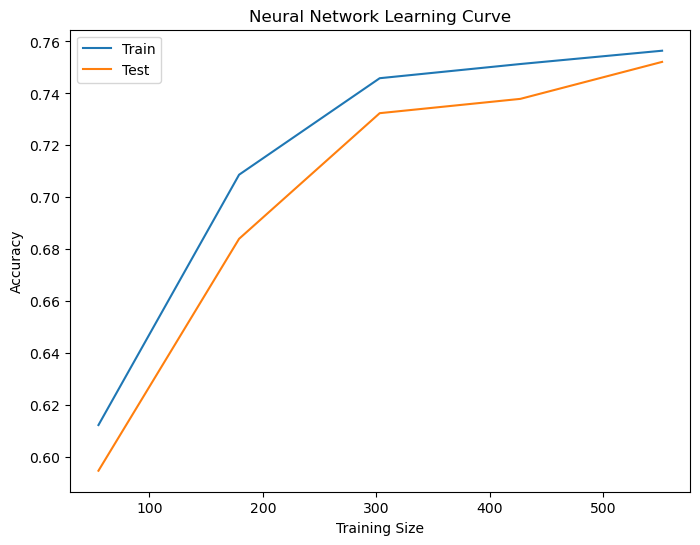

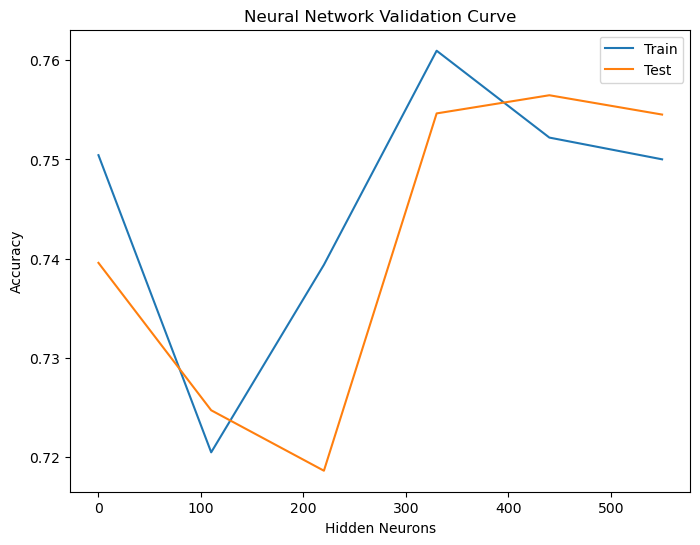

Accuracy: 0.18796992481203006
CPU times: total: 10.9 s
Wall time: 7.71 s


In [17]:
%%time
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train_pima, y_train_pima, cv=10, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train_pima, y_train_pima, param_name="hidden_layer_sizes", param_range=param_range,
    cv=10, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()


accuracy = f1_score(y_test_pima, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")

In [56]:
%%time 
X_train, X_test, y_train, y_test = train_test_split(diabetes_pca, y_pima, test_size=0.2, random_state=42)


#baseline
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train, y_train)
mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train, y_train)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
f1_score(y_test, y_pred, average="weighted")

CPU times: total: 1min 35s
Wall time: 1min 8s


0.6972129351080834

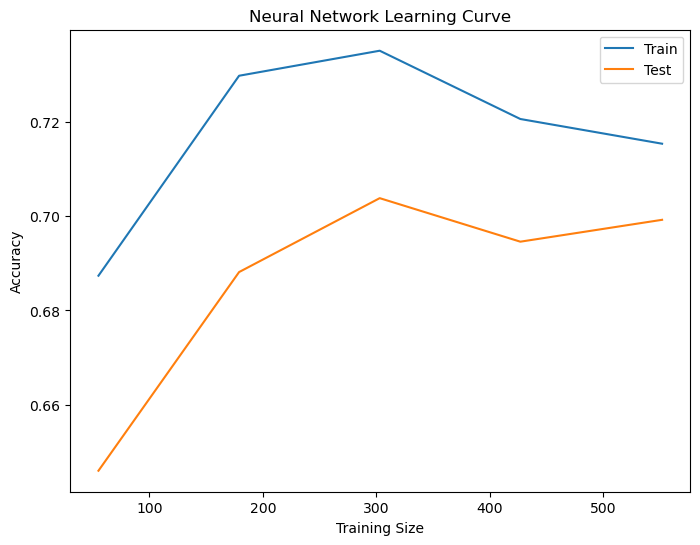

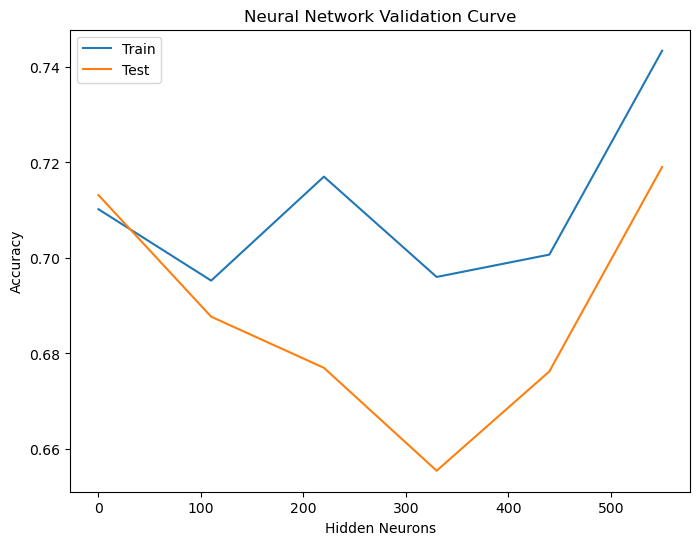

CPU times: total: 12.2 s
Wall time: 9.67 s


In [57]:
%%time
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train, y_train, cv=10, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=10, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79        99
           1       0.62      0.47      0.54        55

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.66       154
weighted avg       0.70      0.71      0.70       154



In [54]:
%%time 
X_train, X_test, y_train, y_test = train_test_split(diabetes_ica, y_pima, test_size=0.2, random_state=42)


#baseline
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train, y_train)
mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train, y_train)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
f1_score(y_test, y_pred, average="weighted")

CPU times: total: 1min 49s
Wall time: 1min 8s


0.7569070080862534

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        99
           1       0.73      0.55      0.62        55

    accuracy                           0.77       154
   macro avg       0.76      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154



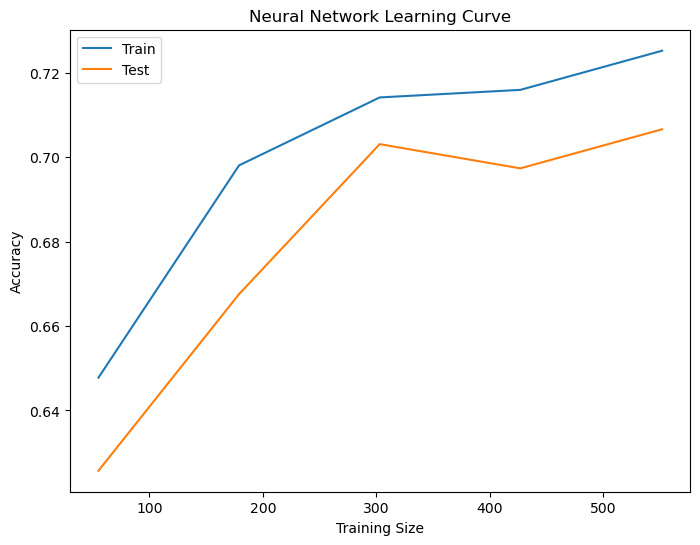

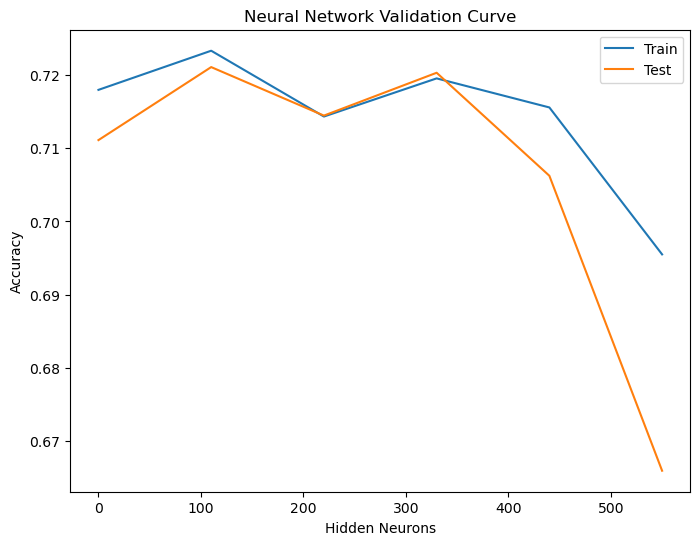

CPU times: total: 10 s
Wall time: 5.57 s


In [45]:
%%time
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train, y_train, cv=10, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=10, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

In [52]:
%%time 
X_train, X_test, y_train, y_test = train_test_split(diabetes_rp, y_pima, test_size=0.2, random_state=42)


#baseline
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train, y_train)
mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train, y_train)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
f1_score(y_test, y_pred, average="weighted")

CPU times: total: 1min 11s
Wall time: 51.3 s


0.6205163511187607

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76        99
           1       0.54      0.27      0.36        55

    accuracy                           0.66       154
   macro avg       0.61      0.57      0.56       154
weighted avg       0.63      0.66      0.62       154



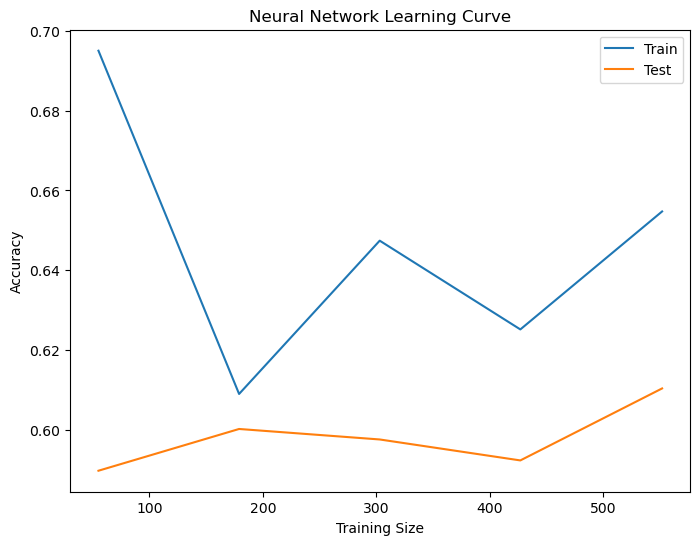

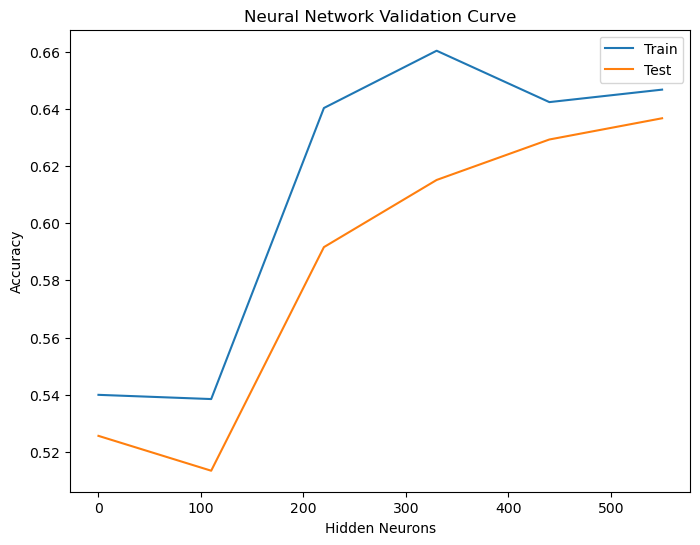

CPU times: total: 14.3 s
Wall time: 8.66 s


In [47]:
%%time
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train, y_train, cv=10, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=10, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

In [48]:
%%time 
X_train, X_test, y_train, y_test = train_test_split(diabetes_tsne, y_pima, test_size=0.2, random_state=42)


#baseline
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train, y_train)
mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train, y_train)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
f1_score(y_test, y_pred, average="weighted")

CPU times: total: 1min 32s
Wall time: 54.5 s


0.67816091954023

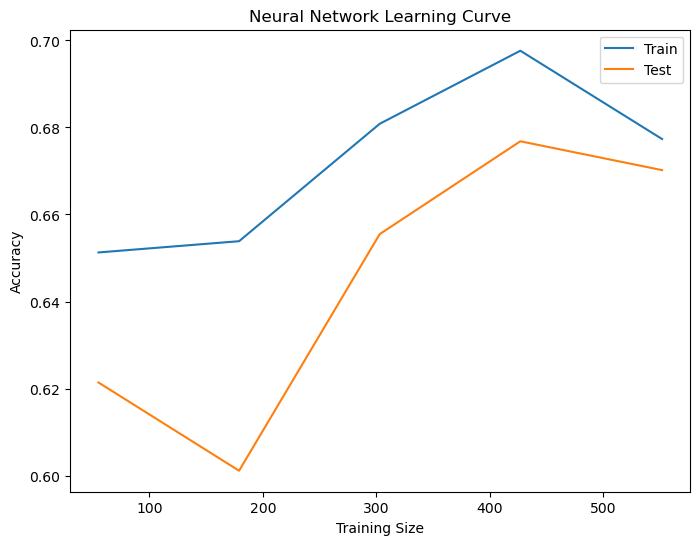

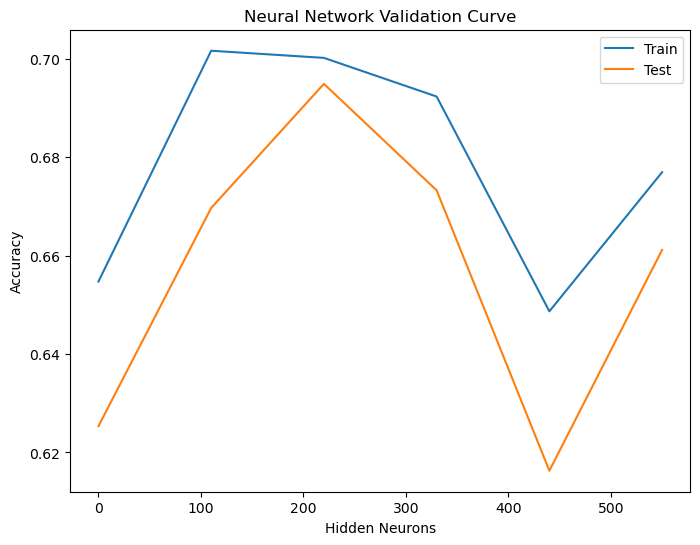

CPU times: total: 13 s
Wall time: 10.3 s


In [49]:
%%time
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train, y_train, cv=10, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=10, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        99
           1       0.56      0.51      0.53        55

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.65       154
weighted avg       0.68      0.68      0.68       154



In [71]:
diabetes_kmeans_clusters= diabetes_kmeans_clusters.reshape(-1,1)
diabetes_kmeans_clusters.shape

(768, 1)

In [76]:
%%time
# Split the updated dataset
X_train, X_test, y_train, y_test = train_test_split(diabetes_kmeans_clusters, y_pima, test_size=0.2, random_state=42)

#baseline
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train, y_train)
mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train, y_train)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
f1_score(y_test, y_pred, average="weighted")

CPU times: total: 1min 38s
Wall time: 56.1 s


0.5031055900621119

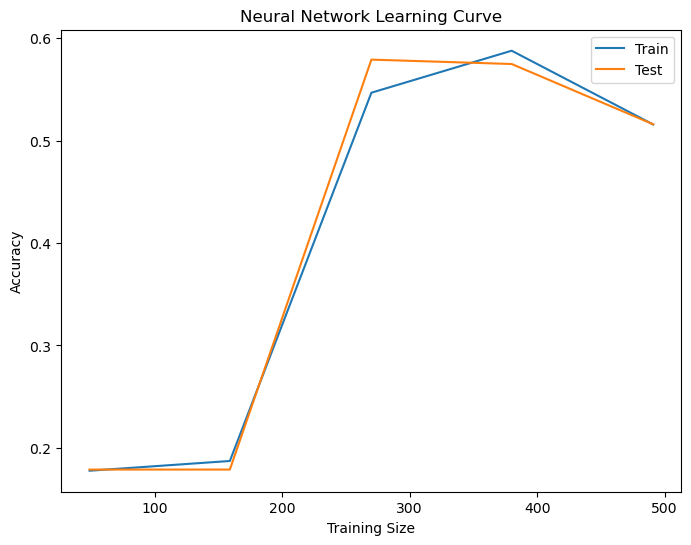

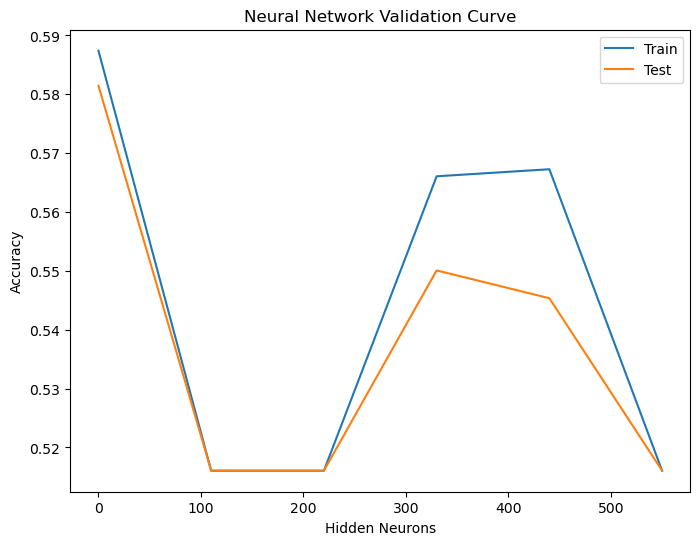

CPU times: total: 4.11 s
Wall time: 2.87 s


In [77]:
%%time
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=5, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

In [79]:
diabetes_em_clusters = diabetes_em_clusters.reshape(-1,1)

In [123]:
%%time
# Split the updated dataset
X_train, X_test, y_train, y_test = train_test_split(diabetes_em_clusters, y_pima, test_size=0.2, random_state=42)

#baseline
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train, y_train)
mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train, y_train)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
f1_score(y_test, y_pred, average="weighted")

CPU times: total: 1min 55s
Wall time: 1min


0.5031055900621119

In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        99
           1       0.00      0.00      0.00        55

    accuracy                           0.64       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.41      0.64      0.50       154



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



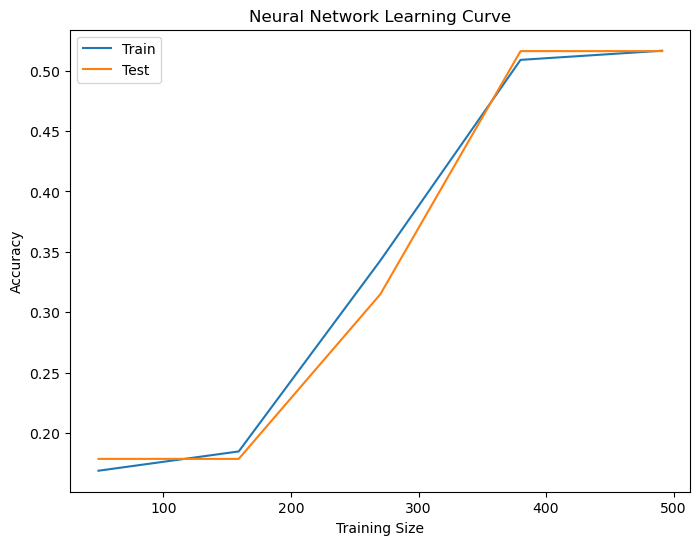

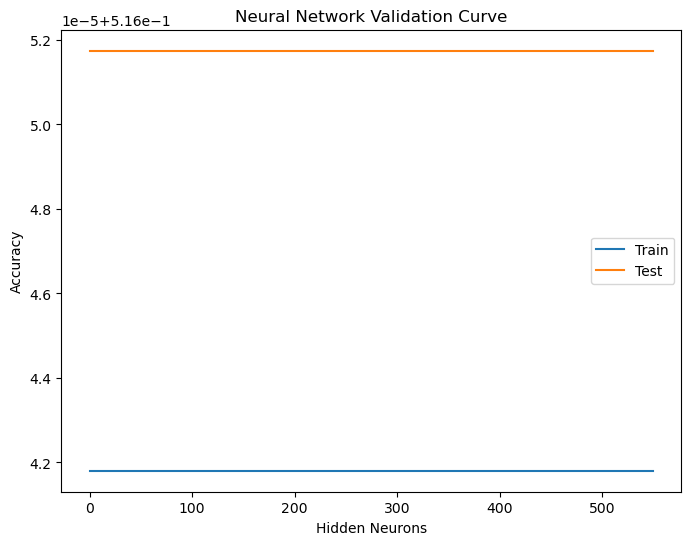

CPU times: total: 4.31 s
Wall time: 2.54 s


In [81]:
%%time
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=5, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        99
           1       0.00      0.00      0.00        55

    accuracy                           0.64       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.41      0.64      0.50       154



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [83]:
pip list --format=freeze > pip-requirements-a3.txt

Note: you may need to restart the kernel to use updated packages.
